I have the clean data from the previous step that includes:

DATE: in datetime format <br>
PRCP: water equivalent (in) or precipitation (if all the snow was melted down to water) <br>
SNOW: new snow measured in inches <br>
SNWD: snow depth measured in inches <br>
TMAX: max temperature observed on that day <br>
TMIN: min temperature observed on that day <br>
TOBS: official observed tempterature observed on that day <br>
MONTH: month separated from Date to make groupby easier <br>
DAY: day separated from Date to make groupby easier <br>
PDO: pacific decadal oscillation; data given by the month but interpolated to the day <br>
AMO: atlantic decadal oscillation; data measure by the month but interpolated to the day <br>
MD: month-day; month and day of the data extract from DATE <br>



In [1]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D
import ppscore as pps

In [2]:
import pickle
path="C:\Springboard\Github\Capstone1_alta\intermediate_data"
os.chdir(path)

In [3]:
ALTA = pickle.load(open("alta_snow_eda.pkl", "rb"))
ALTA.head(10)

,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,MONTH,DAY,PDO,AMO,SNOW7,SNOW14,SNOW30,DEN,MD
0,1944-11-21,0.00,0.0,20.0,52.0,9.0,20.0,11,21,-0.48,0.272,NaN,NaN,NaN,NaN,11-21
1,1944-11-22,0.00,0.0,19.0,48.0,19.0,29.0,11,22,-0.48,0.272,NaN,NaN,NaN,NaN,11-22
2,1944-11-23,0.00,0.0,19.0,56.0,24.0,40.0,11,23,-0.48,0.272,NaN,NaN,NaN,NaN,11-23
3,1944-11-24,0.82,6.0,25.0,52.0,14.0,16.0,11,24,-0.48,0.272,NaN,NaN,NaN,7.317073,11-24
4,1944-11-25,0.06,11.0,36.0,26.0,11.0,14.0,11,25,-0.48,0.272,NaN,NaN,NaN,NaN,11-25
5,1944-11-26,0.00,0.0,36.0,29.0,7.0,16.0,11,26,-0.48,0.272,NaN,NaN,NaN,NaN,11-26
6,1944-11-27,0.00,0.0,34.0,37.0,13.0,20.0,11,27,-0.48,0.272,17.0,NaN,NaN,NaN,11-27
7,1944-11-28,0.25,3.0,37.0,44.0,10.0,12.0,11,28,-0.48,0.272,20.0,NaN,NaN,NaN,11-28
8,1944-11-29,0.00,0.0,35.0,44.0,11.0,30.0,11,29,-0.48,0.272,20.0,NaN,NaN,NaN,11-29
9,1944-11-30,0.00,0.0,33.0,38.0,19.0,25.0,11,30,-0.48,0.272,20.0,NaN,NaN,NaN,11-30


In [4]:
ALTA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21809 entries, 0 to 21808
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    21809 non-null  datetime64[ns]
 1   PRCP    21809 non-null  float64       
 2   SNOW    21809 non-null  float64       
 3   SNWD    21809 non-null  float64       
 4   TMAX    21809 non-null  float64       
 5   TMIN    21809 non-null  float64       
 6   TOBS    21809 non-null  float64       
 7   MONTH   21809 non-null  object        
 8   DAY     21809 non-null  object        
 9   PDO     21808 non-null  float64       
 10  AMO     21808 non-null  float64       
 11  SNOW7   21803 non-null  float64       
 12  SNOW14  21796 non-null  float64       
 13  SNOW30  21780 non-null  float64       
 14  DEN     2084 non-null   float64       
 15  MD      21809 non-null  object        
dtypes: datetime64[ns](1), float64(12), object(3)
memory usage: 2.8+ MB


Let's fill those SNOW7, 14 and 30 so that we don't have NaN in times series.

In [5]:
ALTA['SNOW7'].fillna(value=0, inplace=True)
ALTA['SNOW14'].fillna(value=0, inplace=True)
ALTA['SNOW30'].fillna(value=0, inplace=True)

In [6]:
# import time series stuff
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

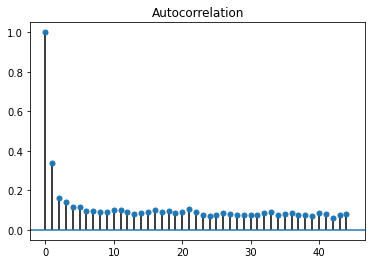

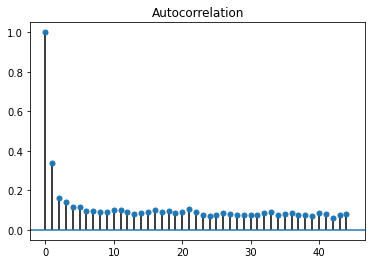

In [7]:
# looking at the standard ACF Plot
plot_acf(ALTA['SNOW'], alpha=1)

That's to be expected. The day's snowfall is closely correlated to the next day. We should also look at percent change and difference between snowfall days to see if there is any autocorrelation there.

In [8]:
diff_snow = ALTA['SNOW'].diff()
pc_snow = ALTA['SNOW'].pct_change()

In [9]:
diff_snow.head()

0    NaN
1    0.0
2    0.0
3    6.0
4    5.0
Name: SNOW, dtype: float64

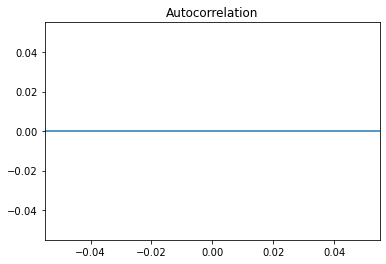

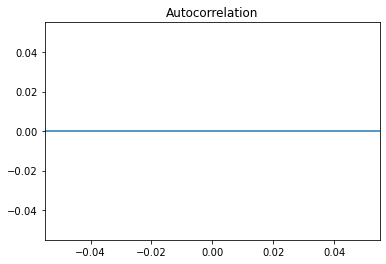

In [10]:
plot_acf(diff_snow, alpha=1)

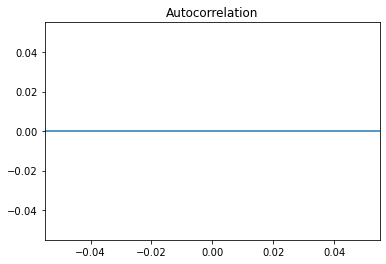

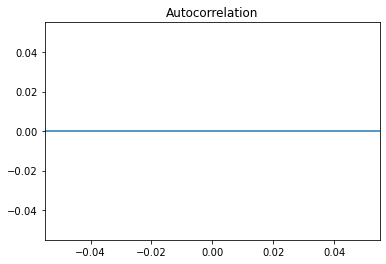

In [11]:
plot_acf(pc_snow, alpha=1)

In [15]:
# let's try to use STUMPY
import stumpy
m = 7
mp = stumpy.stump(ALTA['SNOW'], m)
mp.shape

(21803, 4)

In [19]:
#before plotting, let's find the minimum (sequences that are most like each other)
print(mp[:, 0].min())

0.0


In [29]:
# that number would make sense. Let's find the indices for that value
mp_min = np.where(mp[:,0] == 0)[0]
mp_min.shape

(12300,)

This means that the majority of the values in the matrix profile have values of 0 - they have identical patterns over a 7-day stretch, but that's likely when they don't see any snow. We care about the anamolies. How do we find those?

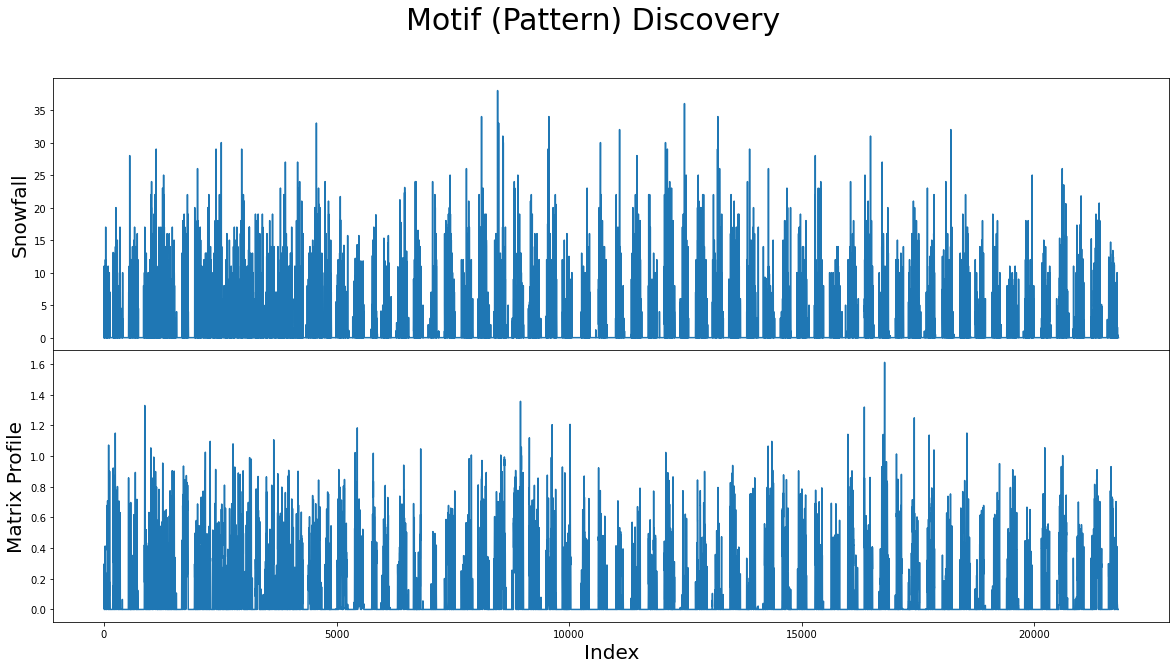

In [31]:
plt.rcParams["figure.figsize"] = (20,10)
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
_ = plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(ALTA['SNOW'].values)
axs[0].set_ylabel('Snowfall', fontsize='20')
#rect = Rectangle((643, 0), m, 40, facecolor='lightgrey')
#axs[0].add_patch(rect)
#rect = Rectangle((8724, 0), m, 40, facecolor='lightgrey')
#axs[0].add_patch(rect)

axs[1].set_xlabel('Index', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
#axs[1].axvline(x=643, linestyle="dashed")
#axs[1].axvline(x=8724, linestyle="dashed")
_ = axs[1].plot(mp[:, 0])

Where do I go from here?